# Predicting Functionality of Water Pumps in Tanzania

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/yemengyuan/Library/Python/3.5/lib/python/site-packages/pandas/tools/plotting.py:983: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


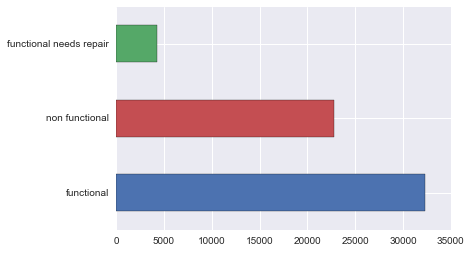

In [2]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 


df_orig=pd.read_csv('../../ML2017_data/bump/x.csv',parse_dates=True)
df_labels=pd.read_csv('../../ML2017_data/bump/y.csv')
df_topredict=pd.read_csv('../../ML2017_data/bump/test_x.csv',parse_dates=True)
df_orig.head()
palette=[sns.color_palette()[0],sns.color_palette()[2],sns.color_palette()[1]]
df_labels.status_group.value_counts().plot(kind='barh', colors=palette)



## Look at data

There are 40 features mostly categorical (+latitude, longitude, gps height). We have 3 labels for the status of the pump: 'functional','functional needs repair','non functional'

Showing below relationship between some categories and labels

ValueError: Length mismatch: Expected axis has 2 elements, new values have 3 elements

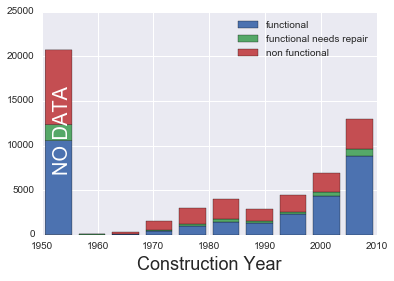

In [6]:
import seaborn as sns

df_orig.construction_year=pd.to_numeric(df_orig.construction_year)
df_orig.loc[df_orig.construction_year <= 0, df_orig.columns=='construction_year'] = 1950

hist1=df_orig[df_labels.status_group == 'functional'].construction_year
hist2=df_orig[df_labels.status_group == 'functional needs repair'].construction_year
hist3=df_orig[df_labels.status_group == 'non functional'].construction_year

n,b,p=plt.hist([hist1, hist2, hist3], stacked=True,range=[1950,2010])
plt.legend(['functional','functional needs repair','non functional'],loc=0)
plt.text(1952, 15000,'NO DATA',fontsize=20,rotation=90,color='white')
plt.xlabel('Construction Year', fontsize=18)

sns.despine()

factorstoplot=['payment','water_quality','source_class','scheme_management','waterpoint_type_group']
for i in range(1,len(factorstoplot)+1):
    df_orig['status'] = pd.Series(df_labels.status_group)
    thisFactor=factorstoplot[i-1]
    sumfactor=df_orig.groupby([thisFactor]).status.count()
    temp=pd.DataFrame(df_orig.groupby([thisFactor]).status.value_counts()/sumfactor)
    temp['status']=temp.index.get_level_values('status')
    temp['source']=temp.index.get_level_values(thisFactor)
    temp.columns=['n','status',thisFactor]
    temp=temp.pivot(index=thisFactor, columns='status', values='n')
    temp['tot']=temp.sum(axis=1)
    temp.sort_values(by='tot', ascending=True)[['functional','functional needs repair','non functional']].plot(kind='barh', stacked='True', color=sns.color_palette(), fontsize=15,legend=False)
    plt.legend( loc='upper right', bbox_to_anchor=(1.9, 0.5),fontsize=15)
    plt.ylabel(thisFactor, fontsize=23)

## Preprocessing

* All missing values of latitude, longitude and height (listed as 0s) are converted to the mean value within their administrative region
* For categorical variables, values that are rare (less than 20 occurences) are converted into "Others"
* Categorical variables are converted into numbers
* A new variable is introduced: timeago (how long ago the pump was checked) 
* Test: these preprocessing steps increase the score of a Random Forest by 5%

In [10]:
df=df_orig.append(df_topredict)

df.construction_year=pd.to_numeric(df.construction_year)
df.loc[df.construction_year <= 0, df.columns=='construction_year'] = 1950


df['operation_time']=df.date_recorded.apply(pd.to_datetime)-df.construction_year.apply(lambda x: pd.to_datetime(x,format='%Y'))# df['timeago']=df.timeago.apply(lambda x: int(x)/100000000000.)
df['operation_time']=df.operation_time.apply(lambda x: float(x)/ (365.25*24*60*60*1e9))
df.loc[df['operation_time'] < 0,df.columns=='operation_time'] = 63.92060232717317

df['month']=pd.to_datetime(df.date_recorded).dt.month


factorschange=[x for x in df.columns if x not in ['id','latitude','longitude','gps_height','date_recorded','construction_year','month','operation_time']]

for factor in factorschange:


    values_factor=df_orig[factor].value_counts()
    lessthen=values_factor[values_factor < 20]
    listnow=df_orig.installer.isin(list(lessthen.keys()))
    df_orig.loc[listnow,factor] = 'Others'

    # names to numbers
    df[factor] = preprocessing.LabelEncoder().fit_transform(df[factor])

df.population = df.population.apply(lambda x: np.log10(x+1))

    
a= df[df["longitude"] < 1]
a.iloc[:,df.columns == "latitude"]= np.nan
a.iloc[:,df.columns == "longitude"]= np.nan
df[df["longitude"] < 1] = a
df["longitude"] = df.groupby("region_code").transform(lambda x: x.fillna(x.mean())).longitude
df["latitude"] = df.groupby("region_code").transform(lambda x: x.fillna(x.mean())).latitude

a= df[df["gps_height"] < 1]
a.iloc[:,df.columns == "gps_height"]= np.nan
df[df["gps_height"] < 1] = a
df["gps_height"] = df.groupby("region_code").transform(lambda x: x.fillna(x.mean())).gps_height

df=df.fillna(df.mean())



df_topredict = df[len(df_orig):]
df = df[:len(df_orig)]





TypeError: float() argument must be a string or a number, not 'Timedelta'

## Split datasets

Create testing and training samples

In [8]:
# use these variables - room for improvement here
factors=[u'funder', u'gps_height',
       u'installer', u'longitude', u'latitude', u'wpt_name',
       u'basin', u'subvillage', u'region', u'region_code', u'district_code',
       u'lga', u'ward', u'population', u'public_meeting',
       u'scheme_management', u'scheme_name', u'permit', u'construction_year',
       u'extraction_type', u'extraction_type_group', u'extraction_type_class',
       u'management', u'management_group', u'payment', u'payment_type',
       u'water_quality', u'quality_group', u'quantity', u'quantity_group',
       u'source', u'source_type', u'source_class', u'waterpoint_type',
       u'waterpoint_type_group','month','operation_time']
# factors = ["funder","installer","management",
#                "region","lga","population",
#                "latitude","longitude","gps_height",
#                "scheme_management",
#                "public_meeting","permit",
#                "water_quality","quantity",
#                "payment_type","source","source_class",
#                "management","management_group",
#                "basin","extraction_type","waterpoint_type",
#                "timeago"]

X_train, X_test, y_train, y_test = train_test_split(df[factors], df_labels.status_group, test_size=0.1, random_state=10)


print len(X_train), len(X_test)


53460 5940


## Train and Score models

* Train a Decision Tree, and a Random Forest
* Score on Test data
* Random Forest recovers ~80% of the variance in the status of the pumps.

53460 5940
Random Forest 0.816835016835
Decision Tree 0.728282828283
Extra Trees Classifiers 0.814983164983


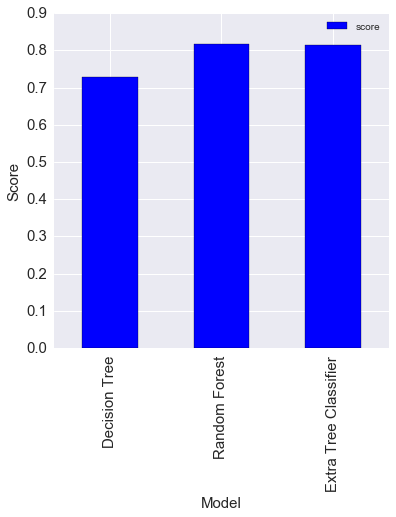

In [9]:
print len(X_train), len(X_test)
modelRFC = RandomForestClassifier(n_estimators=1000,min_samples_split=10,criterion='gini')

X_test=(X_test - X_test.min())/(X_test.max() - X_test.min())
X_train=(X_train - X_train.min())/(X_train.max() - X_train.min())

modelRFC.fit(X_train, y_train)

modelETC = ExtraTreesClassifier(n_estimators=1000,min_samples_split=10)
modelETC.fit(X_train, y_train)


modelDTC = DecisionTreeClassifier()
modelDTC.fit(X_train, y_train)

scoreRFC= modelRFC.score(X_test,y_test)
scoreDTC= modelDTC.score(X_test,y_test)
scoreETC= modelETC.score(X_test,y_test)



print 'Random Forest' ,scoreRFC
print 'Decision Tree', scoreDTC
print 'Extra Trees Classifiers', scoreETC


pd.DataFrame([
    ("Decision Tree", scoreDTC),
    ("Random Forest", scoreRFC),
    ("Extra Tree Classifier", scoreETC),
    ], columns=["Model", "score"]).plot(x="Model", y="score", kind="Bar", fontsize=15)
plt.xlabel('Model', fontsize=15)
plt.ylabel('Score', fontsize=15)

## Confusion Matrix

Showing relation between predicted categories and real categories on the test data.

We are doing fairly well on 'functional' and 'non functional'. 

'Functional needs repair' is the hardest to predict. Most of the real ones end up in 'functional'.

Confusion matrix, without normalization
[[2960   55  253]
 [ 230  128   54]
 [ 474   33 1753]]
Normalized confusion matrix
[[ 0.91  0.02  0.08]
 [ 0.56  0.31  0.13]
 [ 0.21  0.01  0.78]]


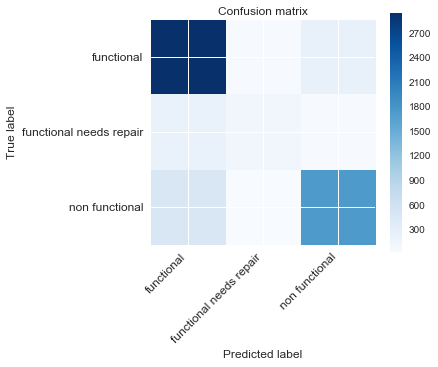

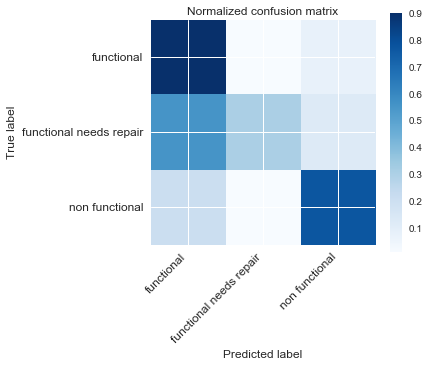

Test Score 0.814983164983


In [10]:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

from sklearn.metrics import confusion_matrix
labels=['functional','functional needs repair','non functional']
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, ha='right', fontsize=12)
    plt.yticks(tick_marks, labels , fontsize=12)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)


# Compute confusion matrix
cm = confusion_matrix(y_test, modelETC.predict(X_test))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()
print 'Test Score', cm.diagonal().sum()/float(cm.sum())

## Fit model

* Train model on entire test dataset
* Predict missing labels and export them

In [6]:
model=modelETC

X_train=df[factors]
y_train =df_labels.status_group
X_train=(X_train - X_train.min())/(X_train.max() - X_train.min())

model.fit(X_train, y_train)



X_topredict=df_topredict[factors]
X_topredict=(X_topredict - X_topredict.min())/(X_topredict.max() - X_topredict.min())
predict=model.predict(X_topredict)


df_topredict['status_group']=predict

df_topredict[['id','status_group']].to_csv('outputETC2.csv',index=False)

## Extra: Finding Optimal Parameters

Using a grid search, and crossvalidation over the entire training set

In [ ]:
from sklearn.cross_validation import cross_val_score

for i in [2,5,10,20]:
    for j in ['auto',5,10,20]:        
        model = RandomForestClassifier(n_estimators=1000,min_samples_split=i,  max_features=j, random_state=3134)
        X_train=df[factors]
        y_train =df_labels.status_group
        X_train=(X_train - X_train.min())/(X_train.max() - X_train.min())
        s=cross_val_score(model, X_train, y_train, scoring=None, cv=None, pre_dispatch='2*n_jobs')
        print i,j,s.mean(), s.std()

In [ ]:
from sklearn.cross_validation import cross_val_score

for i in [2,5,10,20]:
    for j in ['auto',5,10,20]:
        model = ExtraTreesClassifier(n_estimators=1000,min_samples_split=i,  max_features=j, random_state=3134)
        X_train=df[factors]
        y_train =df_labels.status_group
        X_train=(X_train - X_train.min())/(X_train.max() - X_train.min())
        s=cross_val_score(model, X_train, y_train, scoring=None, cv=None, pre_dispatch='2*n_jobs')
        print i,j,s.mean(), s.std()

In [ ]:
10 10 0.80702020202 0.00114354260591
10 20 0.805437710438 0.00143107545706
20 10 0.804932659933 0.00158231247643
20 20 0.805336700337 0.000804213529461